In [25]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

# Importo dataset

In [27]:
folder = '/Users/julianganzabal/.kaggle/competitions/jigsaw-toxic-comment-classification-challenge/'

In [28]:
train = pd.read_csv(folder+"train.csv")
test = pd.read_csv(folder+"test.csv")
test_labels = pd.read_csv(folder+"test_labels.csv")
submission = pd.read_csv(folder+"sample_submission.csv")

In [29]:
train[:10]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [30]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values

In [31]:
y[:10]

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

# Divido entre train y valid

In [32]:
X_train, X_valid, Y_train, Y_valid = train_test_split(train, y, test_size = 0.1)

In [33]:
X_train.shape

(143613, 8)

In [34]:
raw_text_train = X_train["comment_text"].str.lower()
raw_text_valid = X_valid["comment_text"].str.lower()
raw_text_test = test["comment_text"].str.lower()

In [35]:
print(raw_text_train[0:10]) # Recordar que train_test_split hace shuffle 

122668    welcome!\n\nhello, , and welcome to wikipedia!...
28965     |image=dew on a equisetum fluviatile luc viato...
28556     because i'm such a weenie and have social issues,
60409     "\n\nwp:music\nhi jrod2. as i touched on in th...
129868    i have been specific. i did explain why the cu...
36028     f.u.\ni wish you would have better things to d...
34677     """rock critics"" are morons. everyone knows t...
78198     the page is only about 10 mins old. expansion ...
117628    "\nslow down, one thing at a time!!!!  above, ...
77177     "\n\nthere was no discussion to split the arti...
Name: comment_text, dtype: object


In [36]:
Y_train[:10]

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

# Armo matriz de features

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer

max_features = 10000

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=max_features,
                                   stop_words='english')

tfidf_matrix_train = tfidf_vectorizer.fit_transform(raw_text_train)

In [39]:
top_10 = np.argsort(tfidf_matrix_train.sum(axis=0))[0,::-1][0,:10].tolist()[0]

In [40]:
feature_names = np.array(tfidf_vectorizer.get_feature_names())
feature_names[np.array(top_10)]

array(['article', 'talk', 'page', 'wikipedia', 'just', 'like', 'don',
       'thanks', 'edit', 'know'],
      dtype='<U21')

In [41]:
dense_matrix_train = tfidf_matrix_train.todense()

In [42]:
dense_matrix_train.shape, Y_train.shape

((143613, 10000), (143613, 6))

In [43]:
tfidf_matrix_valid = tfidf_vectorizer.transform(raw_text_valid)

In [44]:
dense_matrix_valid = tfidf_matrix_valid.todense()

# Modelo de 1 capa densa

In [45]:
import tensorflow as tf
from keras import backend as K
#-----------------------------------------------------------------------------------------------------------------------------------------------------
# AUC for a binary classifier
def auc(y_true, y_pred):   
    ptas = tf.stack([binary_PTA(y_true,y_pred,k) for k in np.linspace(0, 1, 30)],axis=0)
    pfas = tf.stack([binary_PFA(y_true,y_pred,k) for k in np.linspace(0, 1, 30)],axis=0)
    pfas = tf.concat([tf.ones((1,)) ,pfas],axis=0)
    binSizes = -(pfas[1:]-pfas[:-1])
    s = ptas*binSizes
    return K.sum(s, axis=0)

#-----------------------------------------------------------------------------------------------------------------------------------------------------
# PFA, prob false alert for binary classifier
def binary_PFA(y_true, y_pred, threshold=K.variable(value=0.5)):
    y_pred = K.cast(y_pred >= threshold, 'float32')
    # N = total number of negative labels
    N = K.sum(1 - y_true)
    # FP = total number of false alerts, alerts from the negative class labels
    FP = K.sum(y_pred - y_pred * y_true)    
    return FP/N
#-----------------------------------------------------------------------------------------------------------------------------------------------------
# P_TA prob true alerts for binary classifier
def binary_PTA(y_true, y_pred, threshold=K.variable(value=0.5)):
    y_pred = K.cast(y_pred >= threshold, 'float32')
    # P = total number of positive labels
    P = K.sum(y_true)
    # TP = total number of correct alerts, alerts from the positive class labels
    TP = K.sum(y_pred * y_true)    
    return TP/P

In [46]:
from keras.models import Sequential
from keras import optimizers
from keras.layers.core import Dense, Activation
from helper import PlotLosses
from keras.callbacks import ModelCheckpoint
from keras.initializers import RandomNormal
from keras import regularizers

In [47]:
input_features = dense_matrix_train.shape[1]
output_size = Y_train.shape[1]
hidden_units = 100
lambd = 0 #0.001
model_sig_nn = Sequential()
model_sig_nn.add(Dense(output_size,input_dim=input_features, kernel_regularizer=regularizers.l2(lambd), name="Capa_Oculta"))
model_sig_nn.add(Activation('sigmoid', name="output")) 
model_sig_nn.summary()


lr = 0.01 
batch_size = 1024
epochs = 4

#selectedOptimizer = optimizers.SGD(lr=lr)
selectedOptimizer = optimizers.adam(lr=lr)

# Lo compilo, notar que en vez de binary_crossentropy va categorical_crossentropy
model_sig_nn.compile(loss = 'binary_crossentropy', optimizer=selectedOptimizer, 
                     metrics=['accuracy']) #auc

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Capa_Oculta (Dense)          (None, 6)                 60006     
_________________________________________________________________
output (Activation)          (None, 6)                 0         
Total params: 60,006
Trainable params: 60,006
Non-trainable params: 0
_________________________________________________________________


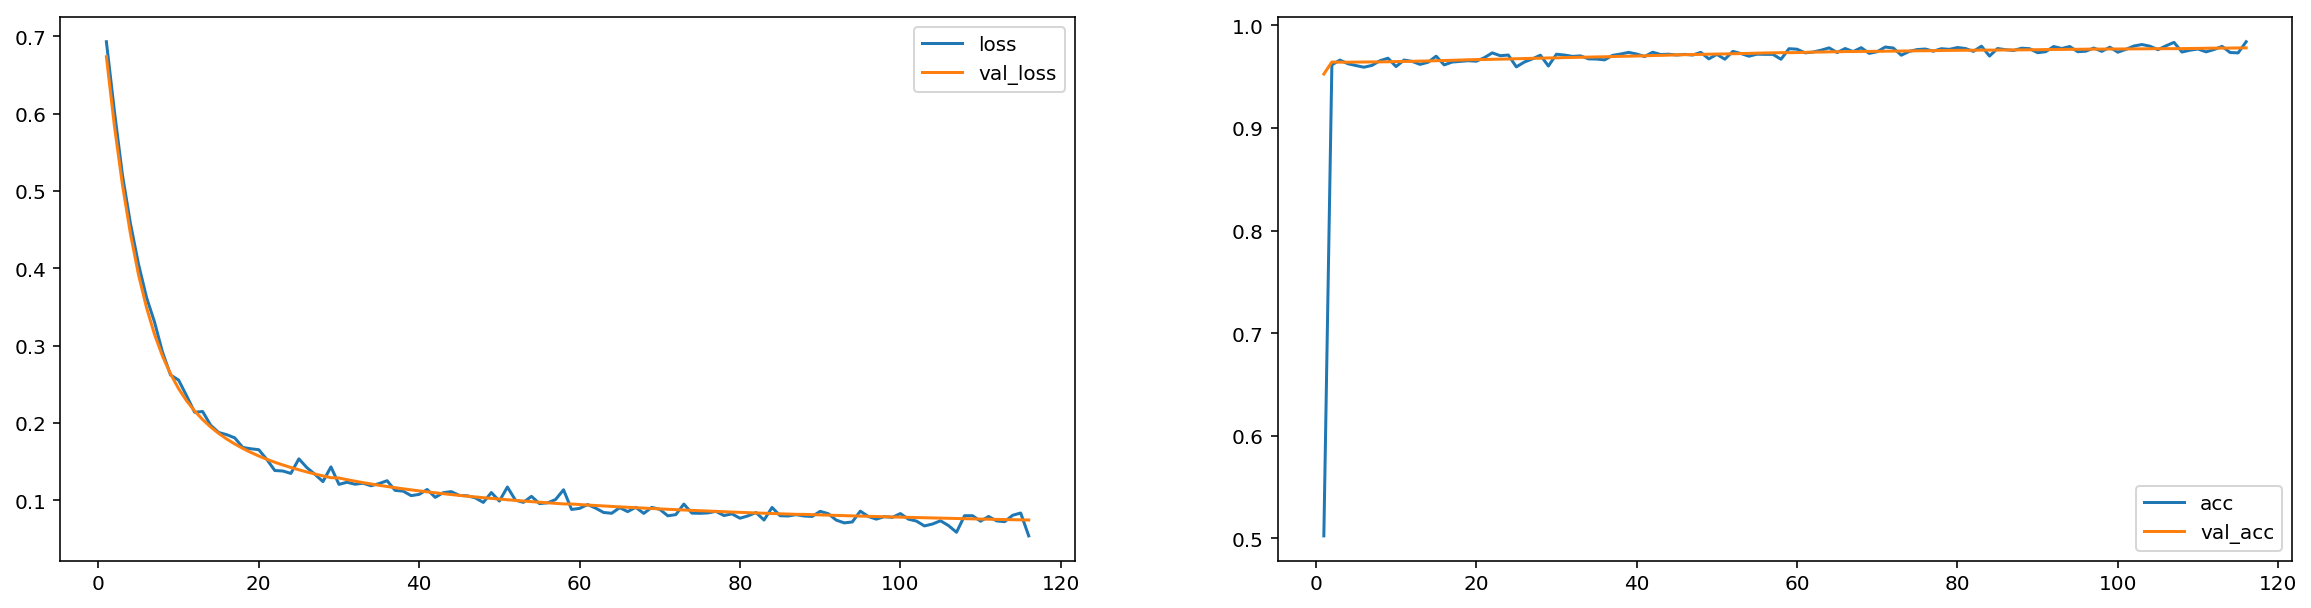

Epoch 00003: val_loss improved from 0.08175 to 0.07439, saving model to basic_model_best.hdf5
143613/143613 [==============================] - 63s - loss: 0.0749 - acc: 0.9775 - val_loss: 0.0744 - val_acc: 0.9782


In [48]:
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='basic_model_best.hdf5', verbose=1, save_best_only=True)

plot_losses = PlotLosses(plot_interval=1, 
                         evaluate_interval=5, 
                         x_val=dense_matrix_valid, 
                         y_val_categorical=Y_valid)
history = model_sig_nn.fit(dense_matrix_train, 
          Y_train, 
          batch_size = batch_size,
          epochs=epochs, 
          verbose=1, 
          validation_data=(dense_matrix_valid, Y_valid), 
          callbacks=[plot_losses, checkpointer],
         )

# Evaluo valid

In [51]:
#model_sig_nn.load_weights('basic_model_best.hdf5')

In [49]:
tfidf_matrix_valid.shape, Y_valid.shape

((15958, 10000), (15958, 6))

In [50]:
pred_valid = model_sig_nn.predict(dense_matrix_valid, verbose = 1)
pred_train = model_sig_nn.predict(dense_matrix_train, verbose = 1)

143488/143613 [============================>.] - ETA: 0s

In [51]:
model_sig_nn.evaluate(dense_matrix_valid, Y_valid)

15840/15958 [============================>.] - ETA: 0s

[0.074389595248441021, 0.9781823123079566]

# ROC Curve

In [52]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

print(roc_auc_score(Y_train, pred_train, average='macro'))
print(roc_auc_score(Y_valid, pred_valid, average='macro'))

0.932876788884
0.907770297568


In [53]:
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = Y_valid.shape[1]
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_valid[:, i], pred_valid[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
fpr["micro"], tpr["micro"], _ = roc_curve(Y_valid.ravel(), pred_valid.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

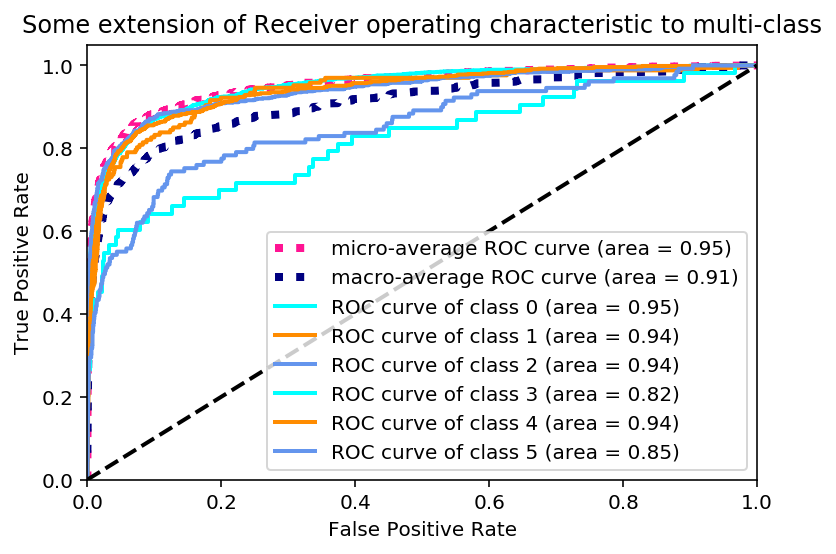

In [54]:
from matplotlib import pyplot as plt
# Compute macro-average ROC curve and ROC area
lw = 2
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

**True Positive Rate**:   
The number of times your system was able to classify the positives as positives. 

True positive rate = Correctly Classified Positives/(Correctly Classified as Positives+ Falsely Classified as Negatives)

**False Positive Rate**:  
The number of times your system classified a negative as a positive divided by the total  actual negative instances.


False positive rate = Incorrectly Classified as Positives/(Incorrectly Classified as Positives+ Correctly classified as Negatives )

https://en.wikipedia.org/wiki/Receiver_operating_characteristic

https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin/16001

Macro-average: Calcula el score de cada clase y luego promedia  
Micro-average: Suma y luego calcula el score

Micro-average se considera mejor cuando hay desbalce en las clases

# Interpretación

- toxic
- severe_toxic
- obscene
- threat
- insult
- identity_hate

In [58]:
(model_sig_nn.get_weights()[0]).shape

(10000, 6)

In [99]:
salida = 3
sorted_indexes = np.argsort(model_sig_nn.get_weights()[0][:,salida])[::-1]
np.array(tfidf_vectorizer.get_feature_names())[sorted_indexes][:20]

array(['kill', 'die', 'rape', 'supertr0ll', 'burn', 'shoot', 'raped',
       'punch', 'hunt', 'throat', 'slowly', 'rvv', 'brains', 'knife',
       'kick', 'destroy', 'billj', 'dies', 'stab', 'hang'],
      dtype='<U21')

# Predict for test

In [ ]:
tfidf_matrix_test = tfidf_vectorizer.transform(raw_text_test)

In [ ]:
dense_matrix_test = tfidf_matrix_test.todense()

In [ ]:
pred = model_sig_nn.predict(dense_matrix_test, verbose=1)

In [ ]:
1*(pred[0:10]>0.5)

In [ ]:
submission[list_classes] = pred
submission.to_csv("submission_early_stop_2_epochs.csv", index = False)

Submit1 ROC AUC en valid = 0.731196488262  
Submit2 ROC AUC en valid = 0.963410980044  
Submit3 ROC AUC en valid = 0.974042855266

In [ ]:
# ~/.local/bin/kaggle competitions submit -c jigsaw-toxic-comment-classification-challenge -f submission_early_stop_2_epochs.csv -m "Early stop 2 epochs"